In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import einsum
from einops import rearrange, reduce, repeat
from typing import Optional, Tuple, List, Union, Dict, Any


### Induction head primer

GPT models are powerful because of their ability to in-context learning. One simple deterministic in-context learning algorithm is the induction operation. It looks straightforward: you look at the current (referred to as the source token) and look at all the tokens that succeed that token in the previous context, and use that information to predict the next token. This is a simple but effective heuristic because compositions of variants of the induction operation can lead to emergent behaviors.

A simple example:

`a b c e e e u y a z t t u i b n a ?`

What will `?` be? The current token is `a`. In the context, the tokens that come after `a` are `b` (at the start) and `z` (in the middle), so the next token – as per the heuristic – is likely to be one of these. We want the probability of the next token here to be equally split between `b` and `z` because both are tokens that come after `a` in the context before. But because `z` is more recent than `b` (which appeared only at the start), another heuristic is that `z` is more likely to be the next token. In any case, we will see how attention can be used to implement this heuristic.

### Reinterpreting attention

While the induction operation above seems like a simple heuristic, how a transformer decoder actually implements it is more involved, which is why we are now going to implement the attention mechanism in a non-standard way. It is equivalent to how it is implemented in "Attention is All You Need" but it is more interpretable and will make it clear how the operation is done.

In [2]:
class Attention(nn.Module):
  def __init__(self, d: int, nh: int, temp: float = 1):
    super().__init__()
    assert d % nh == 0, 'nh must divide d'
    self.d, self.nh = d, nh
    # we'll be skipping wv because wv and wo act together and form the OV circuit
    self.wq = nn.Parameter(rearrange(torch.randn(d, d), 'd (nh dh) -> nh d dh', nh=nh))
    self.wk = nn.Parameter(rearrange(torch.randn(d, d), 'd (nh dh) -> nh d dh', nh=nh))
    self.wov = nn.Parameter(torch.randn(nh, d, d))
    # we'll be skipping layer norm 
    # manually set temp along QK^T rows to make it easier to manually code in mechanisms
    self.temp = temp  

  def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
    # (l, d) @ (nh, l, dh) = (nh, l, dh)
    q, k = x @ self.wq, x @ self.wk  # get queries and keys for each head
    # two steps here
    # (nh, l, dh) @ (nh, dh, l) = (nh, l, l)  (gives all the attn score matrices, which we then softmax)
    # then (nh, l, l) @ (l, d) = (nh, l, d) (all the H_i)
    sx = F.softmax((einsum('hik, hjk -> hij', q, k) + m) / self.temp, -1) @ x # QK circuit
    # now we multiply with wov
    # (nh, l, d) @ (d, d) = (nh, l, d)
    hs = sx @ self.wov
    # then reduction for attention
    attn = reduce(hs, 'nh l d -> l d', 'sum')  # we're just summing across all heads
    return x + attn 

We are just getting the above code out of the way and it's not necessary to look at it in detail for now. We'll first try to gain an intuition about the induction head algorithm, how it could be implemented using the operations of a transformer. A key point here is that induction head circuits form only in two-layer transformer models. To begin understanding how the algorithm can be implemented using the operations of a GPT model, we focus on two primary operations in each attention layer: the query-key (QK) transformation (or "circuit" in interpretability parlance) and the output-value (OV) transformation. These are mechanisms by which the model moves information.

A summary of the mechanism whose details will be clearer soon:

1. The residual stream initially contains current token and its position information
2. The QK transform of the first layer shifts the residual embeddings one position back, so if `sx` is the QK circuit output, it looks like `sx[i] = x[i - 1]` where `x` is the input
3. The OV transform of the first layer takes out the token subspace of `sx` (remember, `sx[i]`'s token subspace is the token subspace of `x[i - 1]`) and moves it to a free (i.e., unoccupied) orthogonal subspace
4. The skip connection of the first layer adds this to the input `x`, so now `x` contains a subspace encoding info about current AND previous token
5. The QK transform of the second layer will now does the main induction op. It must yield `sx` such that `sx[i]` is a linear combination of the residual embeddings of tokens that followed the source token `i`. The effect is that the current token subspace of `sx[i]` is now a linear combination of the token information (embed) of all the tokens that followed token `i` (the source token) in the context.
6. The OV transform of the second layer now takes the current token subspace and writes it some free orthogonal subspace of the residual stream, call it the next token subspace.
7. The skip connection of the second layer adds this to the input `x` and now `x` contains the information, i.e., the embedding of the predicted next token at each position.
8. The logit projection layer picks out the next token subspace and voila

### Residual stream

If you look at the attention code above, just before the return statement, we are summing over `nh` matrices of shape `(l, d)`, i.e., summing over the output of each head, and adding it to the input of the layer. Each head operates independently and adds its output to the residual stream. The residual stream acts as a sort of RAM, from which and _to_ which information gets read and written. Consider the QK transform (line 23) above

`sx = softmax(qk^T) @ x`

We first compute the attention patterns `softmax(qk^T)`. Then we do a mat mul with the input to the attention layer (which, if it's the first layer, is the token embeddings, and if it's an intermediate layer, is the output from the previous layer), and the attention pattern determines what linear combination of input embeddings go in each position. The QK transform therefore decides _from_ which input embedding information is supposed to be transferred from.

Next, we consider the OV transform 

`hs = sx @ wov`

The OV transform `wov` is applied to all the embeddings in parallel. The OV transform picks a particular subspace of each embedding and then chooses the subspace to which it is written to in the residual stream. For example, the `OV` transform could be "move this subspace of an embedding to another subspace and zero out everything else." This is done to all embeddings independently. Every head does some composition of QK and OV transform, and we do the reduction, i.e., sum all head outputs

`attn = reduce(hs, 'nh l d -> l d', 'sum')`

which we then add back to the input (i.e., the residual stream embeddings)

`x = x + attn`

and the above is returned.

### Manually programming two-layer attn model

We'll see how we can manually choose weights for a two-layer attention-only model to do the induction operation. This is a simplification in that in practice, transformers might not have an exact induction head operation (multiple heads can perform the operation to varying degrees), and it may not occur in this exact manner. We'll be making a few simplifying assumptions:

1. We are assuming that the subspaces of the residual stream that are influenced don't overlap
2. We are using naive positional encodings (ala Noam Shazeer's in AIAYN)
3. We'll be using one subspace for the token embedding
4. Initially, the last to subspaces are empty (zeroed out)
5. The subspaces' dimension = head dimension

### What does our initial input look like?

We'll be choosing `d = 1024` and `nh = 4` (4 heads). The input embedding is not the token embedding in its entirety. Only the first 256 dims will be the token embed. The next 256 will be the position embedding (concatenated), then 512 zeroes after. The induction head mechanism will fill the other two subspaces in a particular way that the final logit projection layer will have the necessary information to predict the next token based on the context. We'll use a dummy vocab because it suffices to illustrate the mechanism.

In [3]:
d = 256  # here though, we're just denoting d as token embedding
v = 62 
nh = 4
l = 64

we = nn.Embedding(v, d)  # we.weight = embedding matrix
wout = torch.randn(d, v, requires_grad=True)  # logit projection matrix 

### layer 1: QK transformation

The task of the first attention layer in the two-layer model is to fill the third subspace with the previous token embedding. The first attention layer prepares the residual stream for the second attention layer to process. Remember, the induction operation considers the current token (the source token) and all the tokens that follow the source token in the context. So it helps if the residual embedding at position $m$ has info about both the token at that position and the token at the previous ($m - 1$) position. The QK and OV circuits of the first layer therefore do the task of moving this necessary information into the third subspace of the residual embedding.

The first layer accomplishes this by using the query and key projection matrices to project the position subspace of residual embeddings and use those as queries and keys. The query projection is a block-diagonal matrix that also does one rotation backward. The $m^{\text{th}}$ query will be the $(m - 1)^{\text{th}}$ position encoding, while the $m^{\text{th}}$ key will just be the $m^{\text{th}}$ position encoding. When we consider one query, say the $m^{\text{th}}$ one, and we do dot-product with all keys, $q_{m} \cdot k_{m - 1}$ will be maximum because we have $q_i = k_{i - 1}$ for all $i$. So the attention pattern will look like the identity matrix except the 1s will be shifted one position backward. We'll show this by construction the block diagonal matrix. First we implement the position embedding function.

In [4]:
def get_position_embeddings(l: int, d: int) -> torch.Tensor:
  w = 0.0001 ** (repeat(torch.arange(2, d + 2, 2), 'd -> (d 2)') / d)
  pos = einsum('i, j -> ij', torch.arange(1, l + 1), w)
  pos[:, ::2] = torch.sin(pos[:, ::2])
  pos[:, 1::2] = torch.cos(pos[:, 1::2])
  return pos

We first see how the position embeddings behave. We dot product each position embedding with every other position embedding, take softmax along each row, and see the resulting matrix. We want it to closely resemble an identity matrix. `d = 256`, `l = 64`, and a temperature of 0.3 for softmax seems to work pretty well (smaller `d` = weak attention pattern).

/Users/karthik/Desktop/environments/chat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


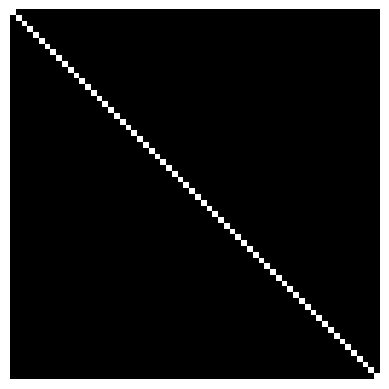

In [5]:
pos = get_position_embeddings(l, d)

temp = 0.3

# prod_ij = \sum_k a_ik b_jk
s = F.softmax(einsum('ik, jk -> ij', pos, pos) / temp, -1).numpy()

plt.axis('off')
plt.imshow(s, cmap='gray')
plt.show()

The argmax along each row has to equal to the row number. We verify this

In [6]:
for i in range(s.shape[0]):
  assert s[i].argmax() == i

We did the above to verify that the QK circuit we are constructing for the first layer works well enough (i.e., the attention pattern is strong enough to snip out just a particular token among all the tokens). Now that we have found `d = 256` for the token and position embeddings is good, our residual stream embeddings `x` are going to be `d = 4 * 256 = 1024`. 

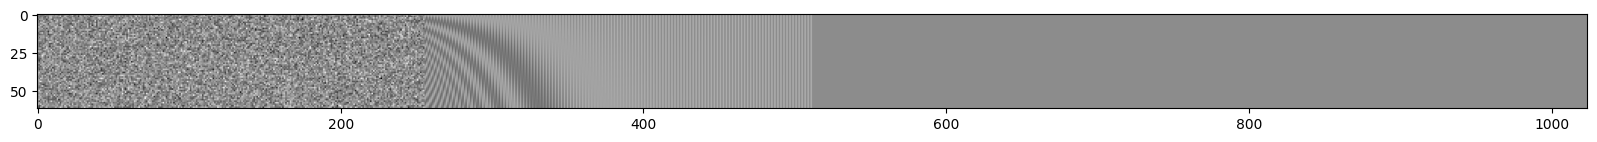

In [7]:
x = torch.zeros(v, d * 4)

pos = get_position_embeddings(v, d)

x[:, :d] += we.weight  # add token embeddings to first subspace
x[:, d:d * 2] += pos  # add positional embeddings to second subspace

fig = plt.figure(figsize=(20, 20))
plt.imshow(x.detach().numpy(), cmap='gray')
plt.show()

Now our task is to construct `wq` for the first layer. `wq` looks like so

$$\begin{bmatrix} [0]_{d_{\text{head}} \times d_{\text{head}}} \\ \text{diag}(R(\theta_1), \ldots, R(\theta_{\frac{d_{\text{head}}}{2}})) \\ [0]_{d_{\text{head}} \times d_{\text{head}}} \\ [0]_{d_{\text{head}} \times d_{\text{head}}} \end{bmatrix}$$

We write a function to construct block-diagonal matrix for given head dimension. There are $d_{\text{head}}$ angles in geometric progression. We need to construct a block diagonal like so

$$\begin{bmatrix}\cos(\theta_1) & \sin(\theta_1) & \ldots & 0 & 0 \\ -\sin(\theta_1) & \cos(\theta_1) & \ldots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \ldots & \cos(\theta_{\frac{d_{\text{head}}}{2}}) & \sin(\theta_{\frac{d_{\text{head}}}{2}}) \\ 0 & 0 & \ldots & -\sin(\theta_{\frac{d_{\text{head}}}{2}}) & \cos(\theta_{\frac{d_{\text{head}}}{2}}) \end{bmatrix}$$

where $d_{\text{head}}$ is 256 here. In our code, `d` refers to $d_{\text{head}}$, when it usually refers to the embedding dimension. Since we're constructing the embedding input, we're going with this.

In [8]:
# sin(xt - x) = cos(x)sin(xt) + (-sin(x))cos(xt) 
# cos(xt - x) = cos(x)cos(xt) + sin(x)sin(xt)

# [sin(xt) cos(xt)] [ cos(x) sin(x)
#                    -sin(x) cos(x) ]

In [9]:
def get_block_diagonal(d: int) -> torch.Tensor:
  angles = 1e-4 ** (torch.arange(2, d + 2, 2) / d)
  bd = torch.eye(d)
  bd[range(0, d, 2), range(0, d, 2)] = torch.cos(angles)
  bd[range(1, d, 2), range(0, d, 2)] = -torch.sin(angles)
  bd[range(0, d, 2), range(1, d, 2)] = torch.sin(angles)
  bd[range(1, d, 2), range(1, d, 2)] = torch.cos(angles)
  return bd

Let's rotate `pos` one step back!

In [10]:
bd = get_block_diagonal(d)
pos_rot = pos @ bd

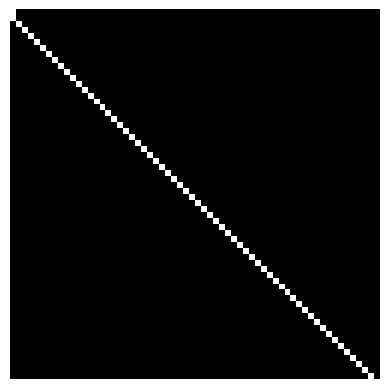

In [11]:
s = F.softmax(einsum('ik, jk -> ij', pos_rot, pos) / temp, -1).numpy()
plt.axis('off')
plt.imshow(s, cmap='gray')
plt.show()

The argmax along each row has to equal to the row number minus 1 _except_ the zeroth position. We verify this

In [12]:
for i in range(s.shape[0]):
  assert s[i].argmax() == max(i - 1, 0)

We can now construct our Q projection matrix `wq`

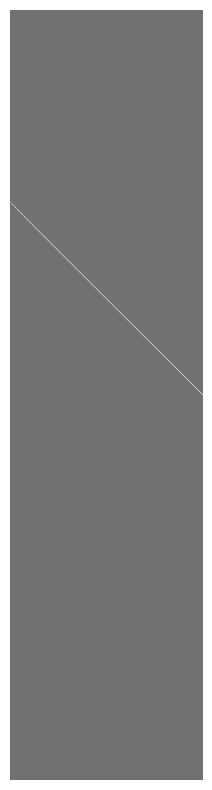

In [13]:
D = 4 * d  # embedding dimension
wq1 = torch.zeros(D, d)
wq1[d:2 * d] = bd  # set the second block to be the block diagonal matrix

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wq1, cmap='gray')
plt.show()

The key projection matrix is going to look like the above but we just have an identity matrix where the diagonal matrix is (the key projection just takes out the position subspace, doesn't rotate it).

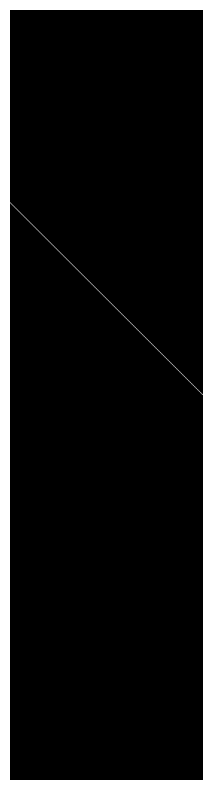

In [14]:
wk1 = torch.zeros(D, d)
wk1[d:2 * d] = torch.eye(d)  # set the second block to be the identity matrix

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wk1, cmap='gray')
plt.show()

Let's check if mechanism works.

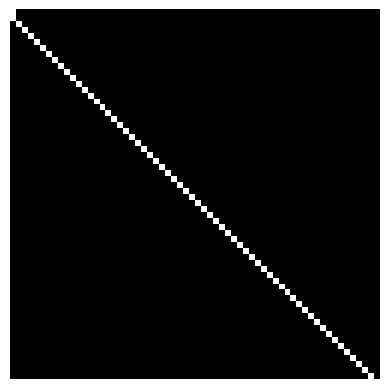

In [15]:
q1 = x @ wq1
k1 = x @ wk1

s = F.softmax(einsum('ik, jk -> ij', q1, k1) / temp, -1)

plt.axis('off')
plt.imshow(s.detach(), cmap='gray')
plt.show()

Asserting if the pattern holds

In [16]:
for i in range(s.shape[0]):
  assert s[i].argmax() == max(i - 1, 0)

and it does :)

We complete the QK circuit by doing a mat mul of `s` with the embeds `x`

In [17]:
qk1 = s @ x

### layer 1: OV transformation

Our next task is to define the `wov` ($W_{OV}$) transformation. This is pretty straightforward: we're moving the current token subspace from `sx[i]` for all `i` to the previous token subspace. It looks like so

$$\begin{bmatrix}
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & I_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} \\
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & 0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & 0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} \\
\end{bmatrix}$$

where `wov` is of shape `(D, D)`

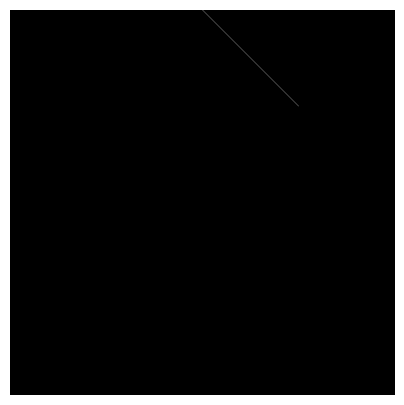

In [18]:
wov1 = torch.zeros(D, D)
wov1[:d, 2 * d:3 * d] = torch.eye(d)  # set the third block to be the identity matrix

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(wov1, cmap='gray')
plt.show()

We multiply the QK circuit out with `wov`

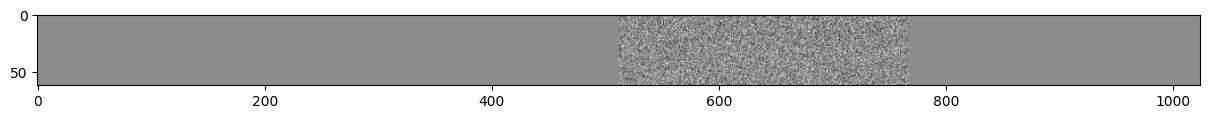

In [19]:
attn1 = qk1 @ wov1

fig = plt.figure(figsize=(15, 15))
plt.imshow(attn1.detach(), cmap='gray')
plt.show()

and then we do the skip connection and add it to the residual stream

In [20]:
x = x + attn1

which completes the operations of the first layer.

### layer 2: QK transformation

The QK transform here is pretty straightforward. `wq` projects the current (or source) token subspace and `wk` projects out the previous token subspace. The $m^{\text{th}}$ key will be the embedding of the $(m - 1)^{\text{th}}$ token (i.e., it encodes information about the previous token at a position). The queries will just be the token embeds. When we do query-key dot product in attention, the query (source token) is going to attend to (i.e., the attn score will be high) all the tokens that come right after the source token in the previous context – therefore, this head is the induction head, doing the main operation. After query-key dot products, we do a matmul with `x` so the embed in the residual stream at position $m$ is a linear combination of the embeds of all the tokens in the context that come right after the token at position $m$. Will be easier to see with a visual 

In [21]:
wq2, wk2 = torch.zeros(D, d), torch.zeros(D, d)

wq2[:d] = torch.eye(d)  # set the first block to be the identity matrix
wk2[2 * d:3 * d] = torch.eye(d) # set the third block to be the identity matrix

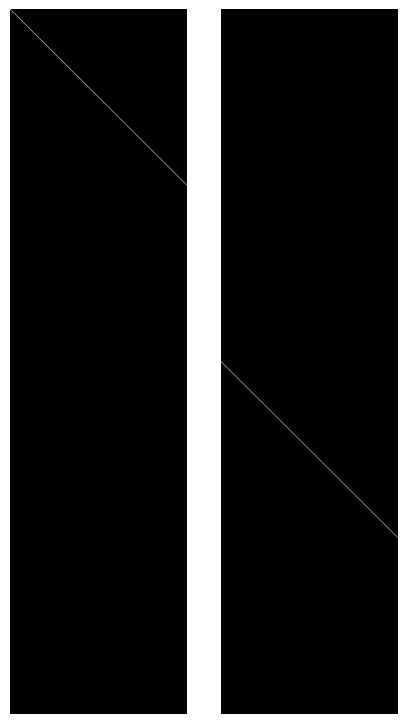

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 10))
ax1.axis('off')
ax1.imshow(wq2, cmap='gray')
ax2.axis('off')
ax2.imshow(wk2, cmap='gray')
plt.show()

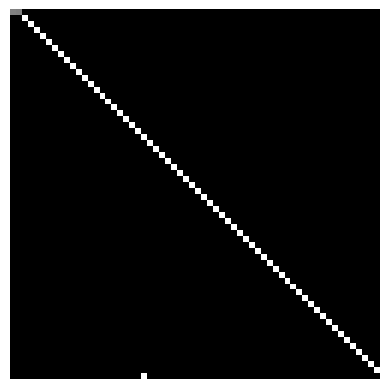

In [23]:
q2 = x @ wq2
k2 = x @ wk2

s = F.softmax(einsum('ik, jk -> ij', q2, k2) / temp, -1)

plt.axis('off')
plt.imshow(s.detach(), cmap='gray')
plt.show()

As expected, we have the argmax at `i + 1` for all rows `i`. This is because the keys are shifted one position back and every token in the input sequence here is unique (just using the embedding matrix as input, i.e., first subspace of `x`), so $q_i \cdot k_{i + 1}$ will be maximum. This gets masked out when doing CausalLM (the score matrix is a lower triangular matrix). We complete the QK circuit 

In [24]:
qk2 = s @ x

which should have taken out the next tokens because that is the linear combination here: in row `i`, score highest for `i + 1` and almost 1, rest all close to 0, so the linear combination using this near one-hot vector on the token embeddings should give us the next token embeds. We can verify this by subtracting `x[i + 1]` from `qk2[i]` and it should give us small values

In [25]:
qk2[5] - x[5 + 1]

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SubBackward0>)

### layer 2: OV transformation

The OV transformation takes out the linear combination in the first subspace and moves it to the next token subspace for the logit projection. `wov` looks like this

$$\begin{bmatrix}
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & 0_{d_{\text{head}} \times d_{\text{head}}} & I_{d_{\text{head}} \times d_{\text{head}}} \\
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & 0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} & \cdots & 0_{d_{\text{head}} \times d_{\text{head}}} & 0_{d_{\text{head}} \times d_{\text{head}}} \\
\end{bmatrix}$$

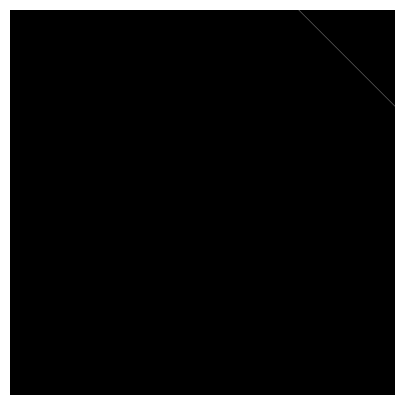

In [26]:
wov2 = torch.zeros(D, D)
wov2[:d, 3 * d:] = torch.eye(d)  # set the third block to be the identity matrix

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(wov2, cmap='gray')
plt.show()

We complete the OV circuit for the second layer

In [27]:
attn2 = qk2 @ wov2

We should expect only the last subspace to have shit in it

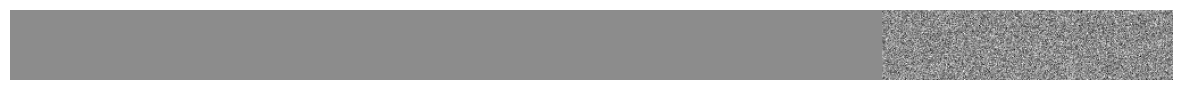

In [28]:
fig = plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(attn2.detach(), cmap='gray')
plt.show()

and once again, we add this to the residual stream using a skip connection

In [29]:
x = x + attn2

Let's consider a single row in `x`, i.e., a single position in the sequence. It contains the following information rn

1. current token embed
2. position embed
3. previous token embed
4. next token embed

Now if at position `i` the embedding has a subspace with the next token embed, it gets easy to predict the next token. Instead of doing a logit projection like in a regular GPT model, it suffices to show that if we take out the last subspace of `x` containing the next token embeds (a tensor of shape `(l, d)`) and the first subspace containing the current token embeds (another tensor of shape `(l, d)`) (here `l` is `v` - the vocab size - because we're just using the embedding matrix) and compute attention scores, we should expect the argmax on row `i` to be `i + 1`, showing that the induction operation has been performed

In [30]:
# take out first subspace
current_tokens = x[:, :d]

# take out last subspace
next_tokens = x[:, 3 * d:]

# verify that current_tokens[i] == next_tokens[i - 1]
current_tokens[5] - next_tokens[5 - 1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

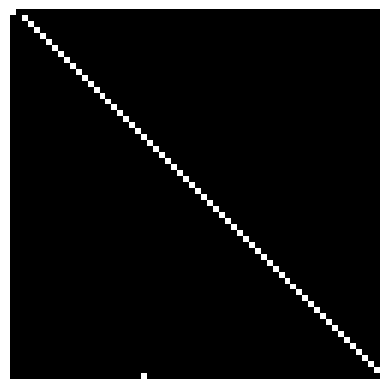

In [31]:
# compute attention scores

s = F.softmax(einsum('ik, jk -> ij', next_tokens, current_tokens) / temp, -1)

plt.axis('off')
plt.imshow(s.detach(), cmap='gray')
plt.show()

### Setting weights

Note that in both layers, we have assumed an embed dimension of `1024` and head dimension of `256` (`nh` is 4), but we're only using 1 head. For the `Attention` module above, we just zero out `wq`, `wk`, and `wov` for other heads and just use one.

In [32]:
A1 = Attention(d=1024, nh=4, temp=0.3)
A2 = Attention(d=1024, nh=4, temp=0.3)

with torch.no_grad():
  # first zero out all parameters
  A1.wq.zero_()
  A1.wk.zero_()
  A1.wov.zero_()
  A2.wq.zero_()
  A2.wk.zero_()
  A2.wov.zero_()

  # set first head of all wq, wk, and wov
  A1.wq[0], A1.wk[0], A1.wov[0] = wq1, wk1, wov1
  A2.wq[0], A2.wk[0], A2.wov[0] = wq2, wk2, wov2

A12 = nn.ModuleList([A1, A2])